# 天池精准医疗大赛

In [6]:
import numpy as np
import pandas as pd
import xlrd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import xgboost as xgb


## 导入数据

In [40]:
train_df = pd.read_csv('data/d_train_20180102.csv', encoding='gbk')
#train_df = pd.read_excel('data/d_train_20180120.xlsx', encoding='gbk')
test_df = pd.read_csv('data/d_test_A_20180102.csv', encoding='gbk')

In [41]:
frames = [train_df, test_df]
data_df = pd.concat(frames, join='outer',ignore_index = True)
data_df = data_df.reindex_axis(train_df.columns, axis=1)

In [42]:
data_df.columns

Index(['id', '性别', '年龄', '体检日期', '*天门冬氨酸氨基转换酶', '*丙氨酸氨基转换酶', '*碱性磷酸酶',
       '*r-谷氨酰基转换酶', '*总蛋白', '白蛋白', '*球蛋白', '白球比例', '甘油三酯', '总胆固醇',
       '高密度脂蛋白胆固醇', '低密度脂蛋白胆固醇', '尿素', '肌酐', '尿酸', '乙肝表面抗原', '乙肝表面抗体', '乙肝e抗原',
       '乙肝e抗体', '乙肝核心抗体', '白细胞计数', '红细胞计数', '血红蛋白', '红细胞压积', '红细胞平均体积',
       '红细胞平均血红蛋白量', '红细胞平均血红蛋白浓度', '红细胞体积分布宽度', '血小板计数', '血小板平均体积',
       '血小板体积分布宽度', '血小板比积', '中性粒细胞%', '淋巴细胞%', '单核细胞%', '嗜酸细胞%', '嗜碱细胞%',
       '血糖'],
      dtype='object')

In [43]:
data_df['AST/ALT'] = data_df['*天门冬氨酸氨基转换酶']/data_df['*丙氨酸氨基转换酶']
data_df['GFR'] = ((data_df['性别']=='男' )+ 0.742*(data_df['性别'] == '女')) * (186 * data_df['肌酐']/88.41 - 1.154*data_df['年龄']-0.203)
data_df['中性粒细胞绝对值'] = data_df['白细胞计数'] * data_df['中性粒细胞%']/100
data_df['淋巴细胞绝对值'] = data_df['白细胞计数'] * data_df['淋巴细胞%']/100
data_df['单核细胞绝对值'] = data_df['白细胞计数'] * data_df['单核细胞%']/100
data_df['嗜酸细胞绝对值'] = data_df['白细胞计数'] * data_df['嗜酸细胞%']/100
data_df['嗜碱细胞绝对值'] = data_df['白细胞计数'] * data_df['嗜碱细胞%']/100

In [44]:
data_df

,id,性别,年龄,体检日期,*天门冬氨酸氨基转换酶,*丙氨酸氨基转换酶,*碱性磷酸酶,*r-谷氨酰基转换酶,*总蛋白,白蛋白,...,嗜酸细胞%,嗜碱细胞%,血糖,AST/ALT,GFR,中性粒细胞绝对值,淋巴细胞绝对值,单核细胞绝对值,嗜酸细胞绝对值,嗜碱细胞绝对值
0,1,男,41,12/10/2017,24.96,23.10,99.59,20.23,76.88,49.60,...,4.7,0.6,6.06,1.080519,115.004208,2.88894,1.82628,0.34710,0.25098,0.03204
1,2,男,41,19/10/2017,24.57,36.25,67.21,79.00,79.43,47.76,...,4.7,0.8,5.39,0.677793,135.769054,3.97800,2.80755,0.44370,0.35955,0.06120
2,3,男,46,26/10/2017,20.82,15.23,63.69,38.17,86.23,48.00,...,3.2,0.8,5.59,1.367039,111.211812,2.21260,1.85380,0.35420,0.14720,0.03680
3,4,女,22,25/10/2017,14.99,10.59,74.08,20.22,70.98,44.02,...,4.6,0.5,4.30,1.415486,76.953312,3.90312,4.35240,0.62712,0.43056,0.04680
4,5,女,48,26/10/2017,20.07,14.78,75.79,22.72,78.05,41.83,...,0.6,0.6,5.42,1.357916,NaN,2.86962,1.67817,0.46137,0.03042,0.03042
5,6,女,74,18/10/2017,23.72,22.59,81.23,23.35,76.46,45.85,...,2.1,1.0,5.97,1.050022,40.544810,3.00300,3.29000,0.49700,0.14700,0.07000
6,7,男,31,21/09/2017,24.97,25.53,109.03,65.42,80.82,46.40,...,3.1,0.7,5.11,0.978065,165.949026,3.60249,2.17920,0.76953,0.21111,0.04767
7,8,男,55,21/09/2017,37.32,40.03,88.49,25.15,74.17,41.63,...,2.8,0.9,5.94,0.932301,130.216379,3.05184,2.13282,0.38148,0.16184,0.05202
8,9,男,39,16/10/2017,21.70,39.17,102.91,67.09,76.12,49.31,...,3.3,0.4,5.66,0.553995,120.089269,3.69576,2.49864,0.50808,0.22968,0.02784
9,10,女,35,10/10/2017,18.89,15.79,78.21,25.75,75.94,46.64,...,1.0,0.7,5.48,1.196327,105.503595,5.84496,2.43243,0.48114,0.08910,0.06237


**删除id, 体检日期两个特征，并且对性别特征one-hot编码**

In [46]:

onehot = pd.get_dummies(data_df['性别'])
data_df = onehot.iloc[:,1:3].join(data_df)
#data_df['性别'] = data_df['性别'].map({'男':1, '女': 0})
data_df.drop(['id','性别','体检日期'],axis=1,inplace=True)
data_df.drop([ '乙肝表面抗原', '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体'],axis=1,inplace=True)

In [55]:
train_size = 5641  #原始数据：5642

In [56]:
columns = ['女', '男', '年龄', '*天门冬氨酸氨基转换酶', '*丙氨酸氨基转换酶', '*碱性磷酸酶', '*r-谷氨酰基转换酶',
       '*总蛋白', '白蛋白', '*球蛋白', '白球比例', '甘油三酯', '总胆固醇', '高密度脂蛋白胆固醇', '低密度脂蛋白胆固醇',
       '尿素', '肌酐', '尿酸', '白细胞计数', '红细胞计数', '血红蛋白', '红细胞压积', '红细胞平均体积',
       '红细胞平均血红蛋白量', '红细胞平均血红蛋白浓度', '红细胞体积分布宽度', '血小板计数', '血小板平均体积',
       '血小板体积分布宽度', '血小板比积', '中性粒细胞%', '淋巴细胞%', '单核细胞%', '嗜酸细胞%', '嗜碱细胞%',
     'AST/ALT', 'GFR', '中性粒细胞绝对值', '淋巴细胞绝对值', '单核细胞绝对值', '嗜酸细胞绝对值',
       '嗜碱细胞绝对值','血糖']
data_df = data_df.reindex_axis(columns, axis=1)

In [57]:
train_df = data_df.iloc[0:train_size,:]
test_df = data_df.iloc[train_size:,:]

In [58]:
test_df.shape

(1000, 43)

In [59]:
x_train = train_df.iloc[:,0:-1]
y_train = train_df.iloc[:,-1]

x_test = test_df.iloc[:,0:-1]

In [60]:
from sklearn.metrics import mean_squared_error
def xg_eval_mae(yhat, dtrain):
    y = dtrain.get_label()
    return 'mae', 1/2*mean_squared_error(y, yhat)

In [61]:
dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)
print('x_train: ',x_train.shape)

x_train:  (5641, 42)


In [152]:
xgb_params = {
    'seed': 0,
    'eta': 0.2,
    'learning_rate':0.1,
    #'min_child_weight':3,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'max_depth':3,     #避免过拟合，值越大，模型会学到更具体更局部的样本，一般3-5
    'min_child_weight':4,
    'reg_lambda':0.2,
    'reg_alpha':10,
    'gamma':0.25,
}

In [153]:
%%time

bst_cv1 = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=5, seed=2, 
                    feval=xg_eval_mae, maximize=False)

print ('CV score:', 1/2 * bst_cv1.iloc[-1,:]['test-rmse-mean']**2)
print ('train score:', 1/2 * bst_cv1.iloc[-1,:]['train-rmse-mean']**2)

CV score: 0.893638505562
train score: 0.625194789274
Wall time: 3 s


In [154]:
bst_cv1.iloc[-1,:]

test-mae-mean      0.897236
test-mae-std       0.112009
test-rmse-mean     1.336891
test-rmse-std      0.084831
train-mae-mean     0.625318
train-mae-std      0.017436
train-rmse-mean    1.118208
train-rmse-std     0.015677
Name: 99, dtype: float64

In [156]:
yhat = np.mean(y_train)
yhat = np.ones((5641)) * yhat
0.5 *mean_squared_error(y_train,yhat)

1.0979654021426999

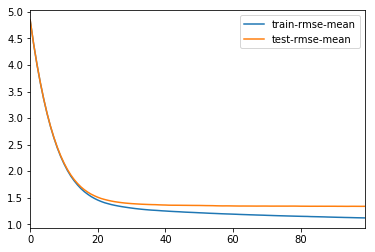

In [157]:
import  matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
bst_cv1[['train-rmse-mean', 'test-rmse-mean']].plot()

In [158]:
bst = xgb.train(xgb_params, dtrain, num_boost_round=100) 
y_train_pred = bst.predict(dtest)


In [159]:
s = pd.Series(y_train_pred) 

In [160]:
s.describe()

count    1000.000000
mean        5.667350
std         0.641103
min         4.706307
25%         5.196807
50%         5.534734
75%         6.013987
max        10.548417
dtype: float64

In [161]:
s.to_csv('result/result9.csv',index = False)